<img src="https://www.nasa.gov/wp-content/uploads/2023/03/704419main_meteor-gif-full_full.gif?w=1041" alt="Bay Area Fireball"></img>
[Bay Area Fireball, October 17, 2012](https://www.nasa.gov/image-article/bay-area-fireball-oct-17-2012/)

# NASA API: World Map of Fireball Impacts

---

## Overview
This notebook will cover all the steps to access bright meteor and fireball impact data collected by NASA's CNEOS and produce a global plot of impact sites

1. Prerequisites
2. CNEOS Overview
3. Imports
4. Access and Organize Data
5. Plot Earth Fireball Impacts
6. Summary

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Matplotlib](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Necessary | Plotting on a data |
| [Intro to GeoPandas](https://geopandas.org/en/stable/) | Necessary | Plotting on a world map |
| [Intro to Pandas](https://foundations.projectpythia.org/core/pandas/pandas.html) | Necessary | Familiarity with working with dataframes |

---

## CNEOS Overivew

A shooting star is a common term for a meteor and form bright trails of light that are often bright enough to be visible during the day. A "fireball" is a term for expectionally bright meteor that enters the Earth's atmosphere at high speeds. A meteor that form fireballs can be over one meter long. A "bolide" typically refers to a fireball that breaks up in the atmosphere. These objects are tracked by the [Center for Near Earth Object Studies (CNEOS)](https://cneos.jpl.nasa.gov/) and information about the Peak Brightness, Velocity, and Joules of energy radiatated can be retrieved from CNEOS via an API

### Fireball Data API

This notebook will query the Fireball API for data from the last decade of observations

JPL's Center for Near-Earth Objects Studies [API "Fireball"](https://ssd-api.jpl.nasa.gov/doc/fireball.html) is an API that will return machine-readable data in the form of a JSON.

All queries to the Fireball Data API make requests to `https://ssd-api.jpl.nasa.gov/fireball.api`

The API accepts different query parameters to filter the data

Directly querying `https://ssd-api.jpl.nasa.gov/fireball.api` will return all the data of fireball impacts in reverse-chronological order

| Parameter | Type | Description |
| --- | --- | --- |
| date-min | string | exclude data earlier than this date `YYYY-MM-DD` or date/time `YYYY-MM-DDThh:mm:ss` |
| date-max | string | exclude data later than this date `YYYY-MM-DD` or date/time `YYYY-MM-DDThh:mm:ss` |
| energy-min | string | exclude data with total-radiated-energy less than this positive value in joules ×1010 (e.g., `0.3` = 0.3×1010 joules) |
| energy-max | string | exclude data with total-radiated-energy greater than this (see energy-min) |
| impact-e-min | string | exclude data with estimated impact energy less than this positive value in kilotons (kt) (e.g., `0.08` kt) |
| impact-e-max | string | exclude data with total-radiated-energy greater than this (see impact-e-min) |
| alt-min | number | exclude data from objects with an altitude less than this (e.g., `22` meaning objects smaller than this) |
| alt-max | number | exclude data from objects with an altitude greater than this (e.g., `17.75` meaning objects larger than this) |
| req-loc | boolean | location (latitude and longitude) required; when set `true`, exclude data without a location |
| req-alt | boolean | altitude required; when set `true`, exclude data without an altitude |
| req-vel-comp | boolean | pre-entry velocity components required; when set `true`, exclude data without pre-entry velocity components |
| vel-comp | boolean | include pre-entry velocity components |
| sort | string | sort data on the specified field: “date”, “energy”, “impact-e”, “vel”, or “alt” (default sort order is ascending: prepend “-“ for descending) |
| limit | number | limit data to the first N results (where N is the specified number and must be an integer value greater than zero) |

Results from API will be returned as JSON with a number of fields

| Field | Description |
| --- | --- |
| date | date/time of peak brightness (GMT) |
| lat | latitude at peak brightness (degrees) |
| lon | longitude at peak brightness (degrees) |
| lat-dir | latitude direction (“N” or “S”) |
| lon-dir | latitude direction (“E” or “W”) |
| alt | altitude above the geoid at peak brightness (km) |
| energy | approximate total radiated energy (10^10 joules) |
| impact-e | approximate total impact energy (kt) |
| vx | pre-entry velocity (Earth centered X component, km/s) |
| vy | pre-entry velocity (Earth centered Y component, km/s) | 
| vz | pre-entry velocity (Earth centered Z component, km/s) |

## Example JSON result

Return the last 3 records `https://ssd-api.jpl.nasa.gov/fireball.api?limit=3`

```
{
    "signature":
        {
            "version":"1.0",
            "source":"NASA/JPL Fireball Data API"
        },
    "count":"3",
    "fields":["date","energy","impact-e","lat","lat-dir","lon","lon-dir","alt","vel"],
    "data":[
        ["2024-06-03 01:13:51","2.6","0.092","63.1","S","53.2","W","60.0",null],
        ["2024-06-01 23:24:59","7.9","0.25","1.0","S","15.9","W","26.5","12.6"],
        ["2024-05-27 03:19:36","8.4","0.26","1.7","N","39.4","W","56.0","39.2"]
    ]
}
```

## Imports

In [120]:
import requests                 # submit API request query
import pandas as pd             # organizes data retrieved by the API
import geopandas                # generate a world map
import matplotlib.pyplot as plt # plotting data

## Request Fireball Data via API

To retrieve all the fireballs recorded in the last decade (2014-2024)

In [121]:
data_since = "2014-01-01"
last_decade_fireball = requests.get(f"https://ssd-api.jpl.nasa.gov/fireball.api?date-min={data_since}")
last_decade_fireball.status_code # 200 is a valid request

200

In [122]:
fireball_json = last_decade_fireball.json()

In [123]:
# print out data labels
print(f"fields = {fireball_json['fields']}")

fields = ['date', 'energy', 'impact-e', 'lat', 'lat-dir', 'lon', 'lon-dir', 'alt', 'vel']


In [124]:
# convert JSON data to a Pandas dataframe
fireball_df = pd.DataFrame(fireball_json["data"], columns=fireball_json["fields"])
fireball_df

,date,energy,impact-e,lat,lat-dir,lon,lon-dir,alt,vel
0,2024-06-03 01:13:51,2.6,0.092,63.1,S,53.2,W,60.0,None
1,2024-06-01 23:24:59,7.9,0.25,1.0,S,15.9,W,26.5,12.6
2,2024-05-27 03:19:36,8.4,0.26,1.7,N,39.4,W,56.0,39.2
3,2024-05-24 16:19:59,5.4,0.18,6.6,N,114.2,E,42.0,36.5
4,2024-05-18 22:46:50,3.7,0.13,41.0,N,8.8,W,74.3,40.4
...,...,...,...,...,...,...,...,...,...
375,2014-02-18 12:50:44,2.6,0.092,32.8,S,61.5,W,None,None
376,2014-02-13 06:47:42,63,1.5,13.3,N,110.7,W,25.0,None
377,2014-01-15 02:46:19,14.0,0.41,18.5,S,141.8,E,29.6,None
378,2014-01-12 16:00:48,7.8,0.24,2.9,N,64.4,E,37.0,16.2


In [125]:
# remove nan and duplicated data rows and reindex rows
fireball_df.dropna(inplace=True, ignore_index=True)

# convert columnss from strings to a float
fireball_df["energy"] = fireball_df["energy"].astype(float)
fireball_df["impact-e"] = fireball_df["impact-e"].astype(float)
fireball_df["lat"] = fireball_df["lat"].astype(float)
fireball_df["lon"] = fireball_df["lon"].astype(float)
fireball_df["alt"] = fireball_df["alt"].astype(float)
fireball_df["vel"] = fireball_df["vel"].astype(float)

# convert latitude to negative if lat-dir is S and longitude to negative if lon-dir is W
fireball_df['lat'] = fireball_df['lat'].mask(fireball_df['lat-dir'].eq('S'), -fireball_df['lat'])
fireball_df['lon'] = fireball_df['lon'].mask(fireball_df['lon-dir'].eq('W'), -fireball_df['lon'])

# rename columns
fireball_df = fireball_df.rename(columns= {"impact-e": "impact energy",
                                           "lat": "latitude",
                                           "lat-dir": "latitude direction",
                                           "lon": "longitude",
                                           "lon-dir": "longitude direction",
                                           "alt": "altitude",
                                           "vel": "velocity"})


fireball_df

,date,energy,impact energy,latitude,latitude direction,longitude,longitude direction,altitude,velocity
0,2024-06-01 23:24:59,7.9,0.25,-1.0,S,-15.9,W,26.5,12.6
1,2024-05-27 03:19:36,8.4,0.26,1.7,N,-39.4,W,56.0,39.2
2,2024-05-24 16:19:59,5.4,0.18,6.6,N,114.2,E,42.0,36.5
3,2024-05-18 22:46:50,3.7,0.13,41.0,N,-8.8,W,74.3,40.4
4,2024-05-05 20:11:03,3.7,0.13,-7.1,S,-112.7,W,39.0,13.9
...,...,...,...,...,...,...,...,...,...
208,2014-05-16 12:42:48,30.9,0.82,-44.2,S,-176.2,W,44.0,16.5
209,2014-05-08 19:42:37,105.0,2.40,-36.9,S,87.3,E,35.4,19.0
210,2014-03-29 13:45:41,3.9,0.13,-28.7,S,121.5,E,30.7,16.3
211,2014-01-12 16:00:48,7.8,0.24,2.9,N,64.4,E,37.0,16.2


In [126]:
fireball_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 213 non-null    object 
 1   energy               213 non-null    float64
 2   impact energy        213 non-null    float64
 3   latitude             213 non-null    float64
 4   latitude direction   213 non-null    object 
 5   longitude            213 non-null    float64
 6   longitude direction  213 non-null    object 
 7   altitude             213 non-null    float64
 8   velocity             213 non-null    float64
dtypes: float64(6), object(3)
memory usage: 15.1+ KB


### Plot the Energy of Fireballs

/tmp/ipykernel_7442/1829906866.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_map = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


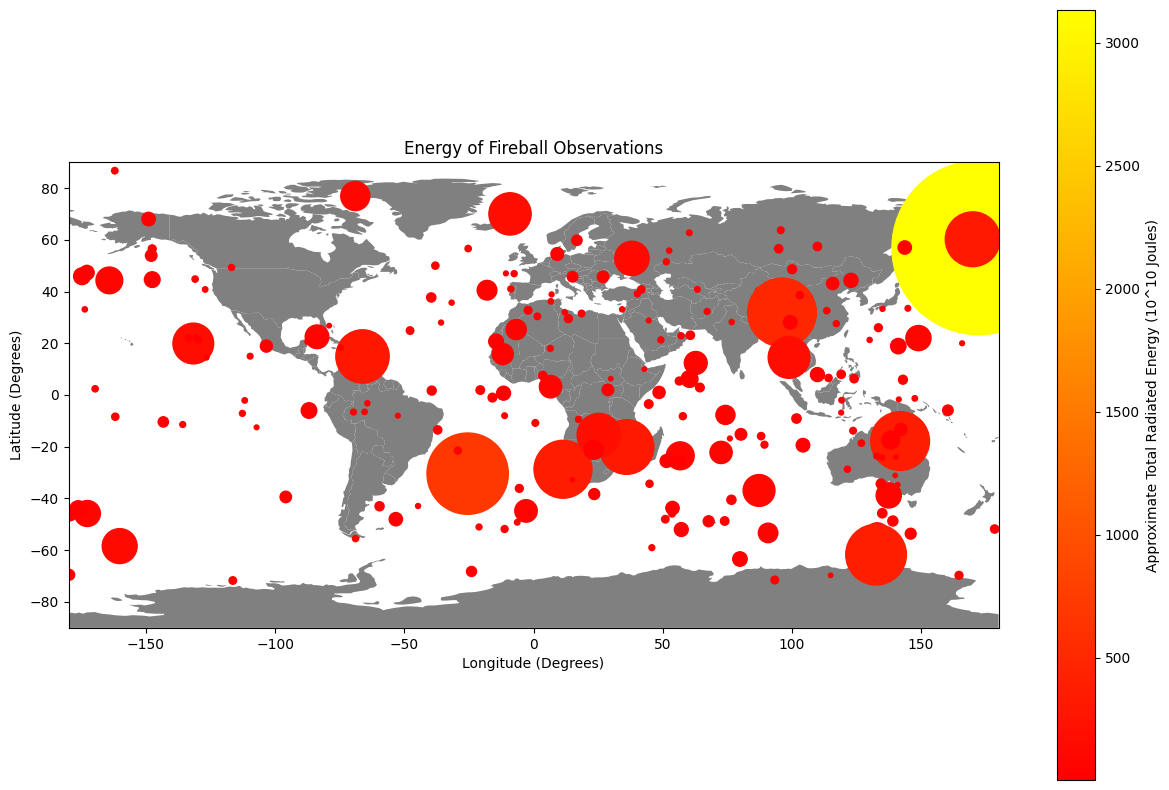

In [127]:
# retrieve world map from GeoPandas
world_map = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

# Set up world map plot
fig, ax = plt.subplots(figsize=(15, 10))
world_map.plot(color="grey", ax=ax)

# Plot Fireball Locations with Energy
x = fireball_df["longitude"]
y = fireball_df["latitude"]
z = fireball_df["energy"]
plt.scatter(x, y, s=5*z, c=z, cmap="autumn")
plt.colorbar(label="Approximate Total Radiated Energy (10^10 Joules)")

# Setup Axis Limits and Title/Labels
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.title("Energy of Fireball Observations")
plt.xlabel("Longitude (Degrees)")
plt.ylabel("Latitude (Degrees)")
plt.show()

### Plot the Impact Energy of Fireballs

/tmp/ipykernel_7442/3576206611.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_map = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


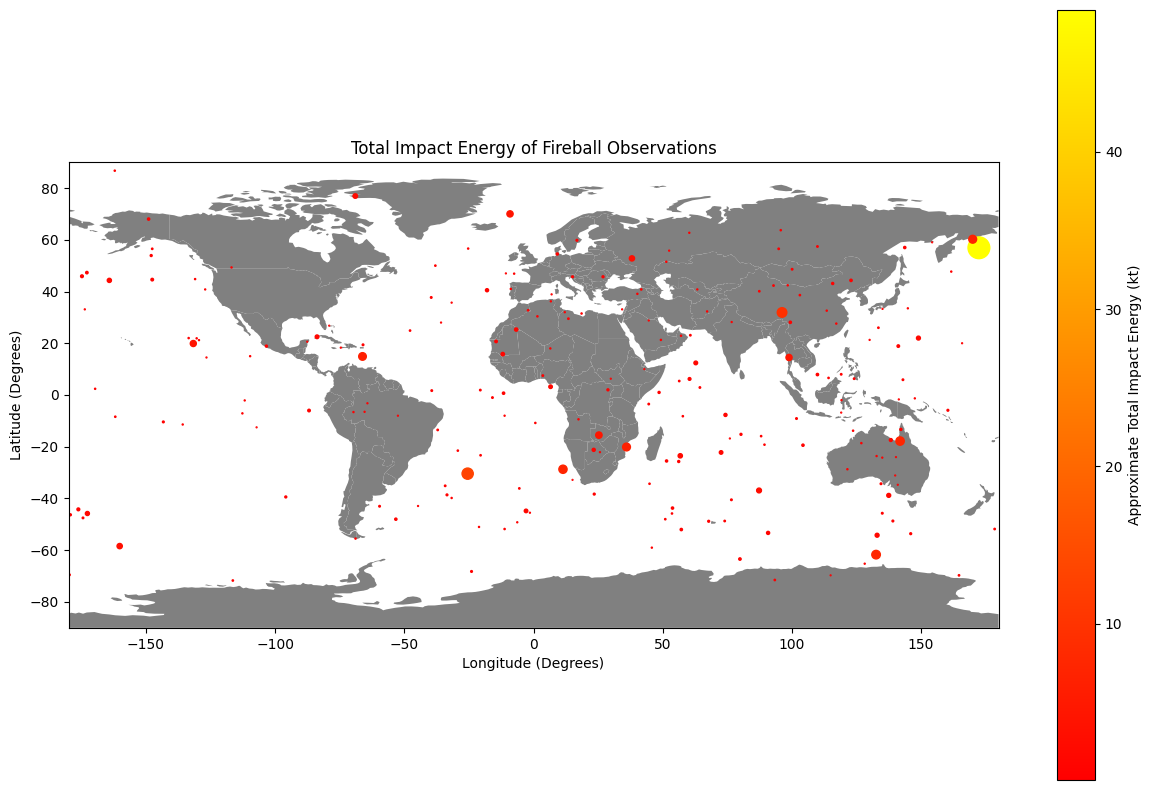

In [128]:
# retrieve world map from GeoPandas
world_map = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

# Set up world map plot
fig, ax = plt.subplots(figsize=(15, 10))
world_map.plot(color="grey", ax=ax)

# Plot Fireball Locations with Energy
x = fireball_df["longitude"]
y = fireball_df["latitude"]
z = fireball_df["impact energy"]
plt.scatter(x, y, s=5*z, c=z, cmap="autumn")
plt.colorbar(label="Approximate Total Impact Energy (kt)")

# Setup Axis Limits and Title/Labels
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.title("Total Impact Energy of Fireball Observations")
plt.xlabel("Longitude (Degrees)")
plt.ylabel("Latitude (Degrees)")
plt.show()

### Plot the Velocity of Fireballs

/tmp/ipykernel_7442/1005838665.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_map = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


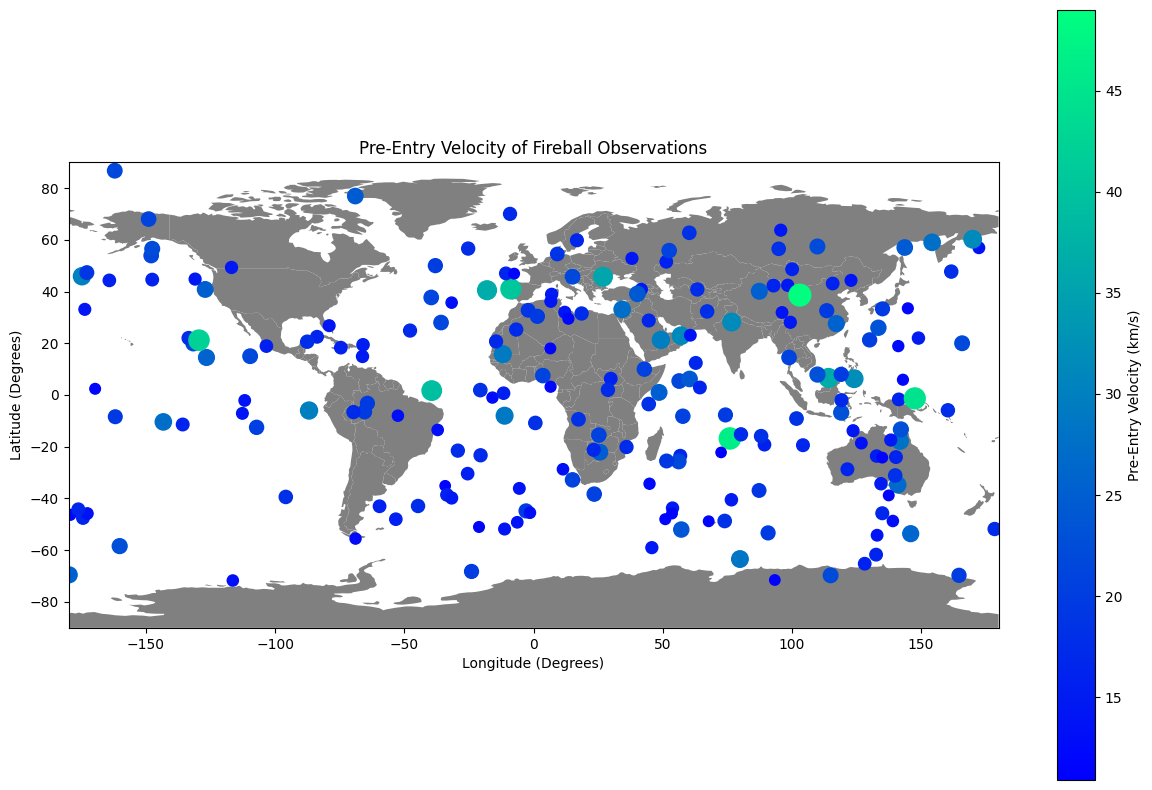

In [129]:
# retrieve world map from GeoPandas
world_map = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

# Set up world map plot
fig, ax = plt.subplots(figsize=(15, 10))
world_map.plot(color="grey", ax=ax)

# Plot Fireball Locations with Velocity
x = fireball_df["longitude"]
y = fireball_df["latitude"]
z = fireball_df["velocity"]
plt.scatter(x, y, s=5*z, c=z, cmap="winter")
plt.colorbar(label="Pre-Entry Velocity (km/s)")

# Setup Axis Limits and Title/Labels
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.title("Pre-Entry Velocity of Fireball Observations")
plt.xlabel("Longitude (Degrees)")
plt.ylabel("Latitude (Degrees)")
plt.show()

### Plot the Altitude of Fireballs

/tmp/ipykernel_7442/3372262186.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_map = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


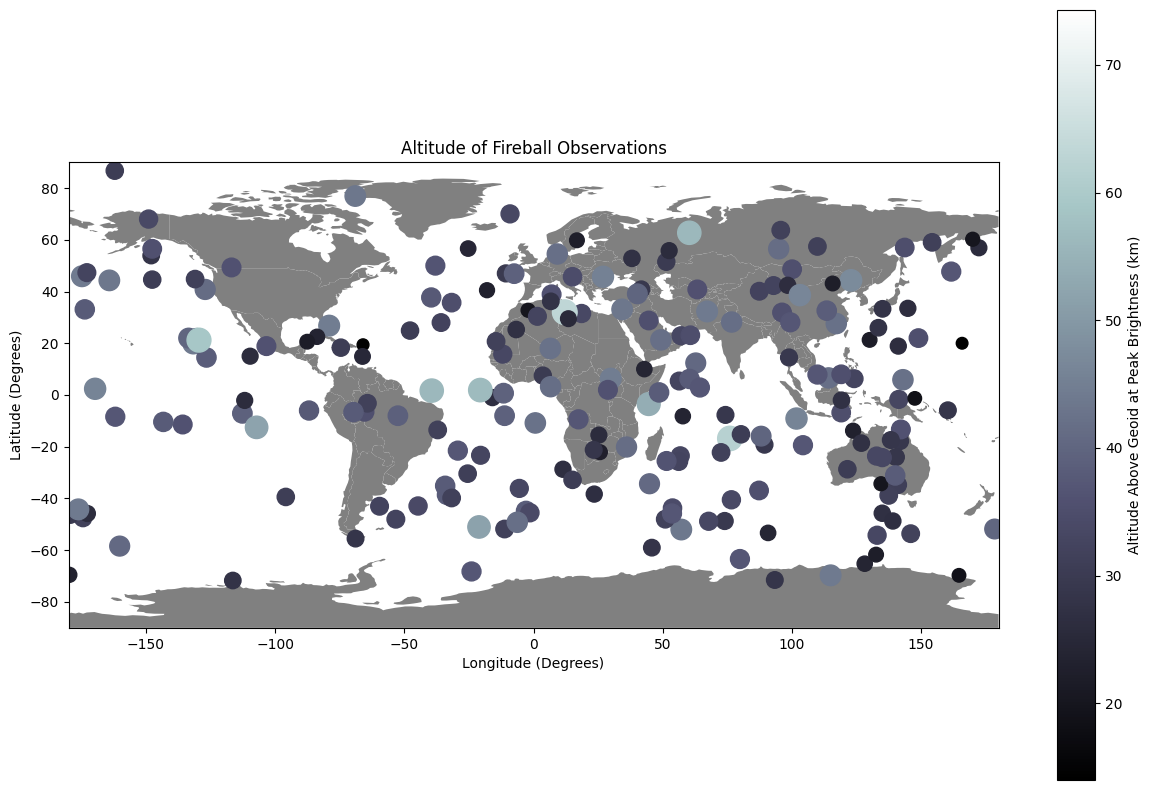

In [130]:
# retrieve world map from GeoPandas
world_map = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

# Set up world map plot
fig, ax = plt.subplots(figsize=(15, 10))
world_map.plot(color="grey", ax=ax)

# Plot Fireball Locations with Energy
x = fireball_df["longitude"]
y = fireball_df["latitude"]
z = fireball_df["altitude"]
plt.scatter(x, y, s=5*z, c=z, cmap="bone")
plt.colorbar(label="Altitude Above Geoid at Peak Brightness (km)")

# Setup Axis Limits and Title/Labels
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.title("Altitude of Fireball Observations")
plt.xlabel("Longitude (Degrees)")
plt.ylabel("Latitude (Degrees)")
plt.show()

## Last Section

If you're comfortable, and as we briefly used for our embedded logo up top, you can embed raw html into Jupyter Markdown cells (edit to see):

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Your relevant information here!
</div>

Feel free to copy this around and edit or play around with yourself. Some other `admonitions` you can put in:

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">Success</p>
    We got this done after all!
</div>

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Be careful!
</div>

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Danger</p>
    Scary stuff be here.
</div>

We also suggest checking out Jupyter Book's [brief demonstration](https://jupyterbook.org/content/metadata.html#jupyter-cell-tags) on adding cell tags to your cells in Jupyter Notebook, Lab, or manually. Using these cell tags can allow you to [customize](https://jupyterbook.org/interactive/hiding.html) how your code content is displayed and even [demonstrate errors](https://jupyterbook.org/content/execute.html#dealing-with-code-that-raises-errors) without altogether crashing our loyal army of machines!

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references

 - More information about [plotting a world map with GeoPandas](https://medium.com/@kavee625/plotting-data-on-the-world-map-with-geopandas-f03742615196)